In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dgp_palette = sns.color_palette("pastel", 6)
color_map_dgps = {f'dgp{i+1}': dgp_palette[i] for i in range(6)}

import matplotlib.pyplot as plt

tab10 = plt.get_cmap("tab10").colors

color_map_models = {
    'lasso': tab10[0],     
    'rf': tab10[1],        
    'xgb': tab10[2],       
    'stacking': tab10[3],  
    'oracle': tab10[4],     
    'combined_loss': tab10[5], 
    'y_error': tab10[6]  
}

hatch_map_models = {
    'lasso': '//',
    'rf': '\\\\',
    'xgb': 'xx',
    'stacking': '..',
    'oracle': '**'
}

linestyle_map_models = {
    'lasso': 'solid',
    'rf': 'dashed',
    'xgb': 'dotted',
    'stacking': 'dashdot',
    'oracle': (0, (3, 1, 1, 1))
}

marker_map_models = {
    'lasso': 'o',
    'rf': 's',
    'xgb': '^',
    'stacking': 'D',
    'oracle': 'P'
}

In [3]:
dfs = defaultdict(dict)

dgps = ['dgp1', 'dgp2', 'dgp3', 'dgp4', 'dgp5', 'dgp6']
models = ['lasso', 'rf', 'xgb', 'stacking', 'oracle']
models_without_oracle = ['lasso', 'rf', 'xgb', 'stacking']

for dgp in dgps:
    dfs[dgp] = pd.read_csv(f'results_MNAR_{dgp}_on_folds.csv')

# rRMSE Bias

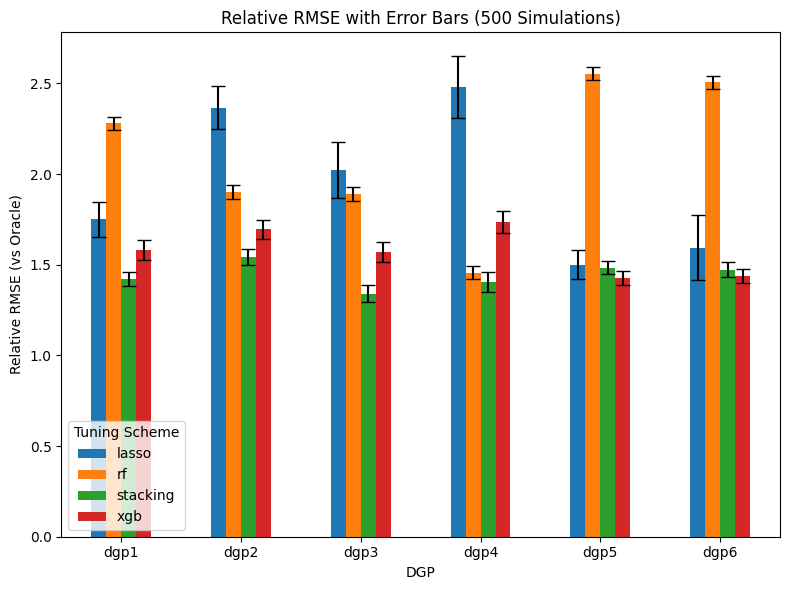

In [6]:
relative_rmses = {}
relative_se = {}

for dgp in dgps:
    oracle_bias = dfs[dgp][dfs[dgp]['model']=='oracle']['bias']
    rmse_oracle = np.sqrt(np.mean(oracle_bias**2))
    
    for model_type in models_without_oracle:
        df_temp = dfs[dgp][dfs[dgp]['model'] == model_type]
        bias = df_temp['bias']
        rmse_current = np.sqrt(np.mean(bias**2))
        
        # rRMSE
        rel_rmse = rmse_current / rmse_oracle
        relative_rmses[(dgp, model_type)] = rel_rmse
        
        # Delta method approximation for SE:
        # Var(X/Y) ≈ (1/Y²) * Var(X)   (assuming Y is constant here, since oracle is fixed)
        n = len(bias)
        var_rmse_current = np.var(bias**2) / (4 * n * rmse_current**2)  # delta method
        se_rel_rmse = np.sqrt(var_rmse_current) / rmse_oracle
        relative_se[(dgp, model_type)] = se_rel_rmse

# Barplot
df_plot = pd.Series(relative_rmses).unstack()
df_se = pd.Series(relative_se).unstack()

fig, ax = plt.subplots(figsize=(8, 6))
df_plot.plot(kind='bar', yerr=df_se, capsize=5, ax=ax)

ax.set_ylabel("Relative RMSE (vs Oracle)")
ax.set_title("Relative RMSE with Error Bars (500 Simulations)")
ax.set_xlabel("DGP")
ax.legend(title="Tuning Scheme")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


# relative RMSE gathered

In [7]:
df_rmses = pd.DataFrame([
    {"DGP": dgp, "Model": model, "Relative RMSE": relative_rmses[(dgp, model)]}
    for (dgp, model) in relative_rmses
])

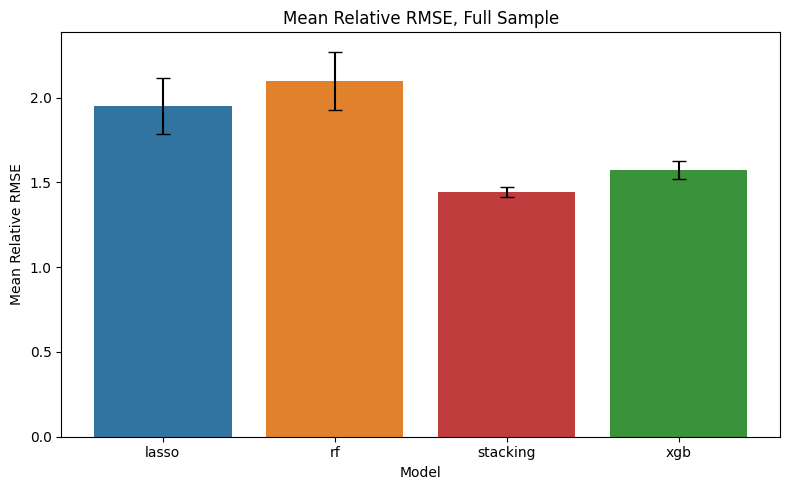

In [9]:
df_bar = (
    df_rmses.groupby("Model")["Relative RMSE"]
    .agg(["mean", "sem"])
    .reset_index()
    .rename(columns={"mean": "Mean Relative RMSE", "sem": "SE"})
)

plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=df_bar, 
    x="Model", 
    y="Mean Relative RMSE", 
    hue ="Model",
    palette=[color_map_models.get(model, '#333333') for model in df_bar['Model']],
    capsize=0.1
)

for i, row in df_bar.iterrows():
    x = i
    y = row["Mean Relative RMSE"]
    se = row["SE"]
    ax.errorbar(x=x, y=y, yerr=se, fmt='none', c='black', capsize=5, linewidth=1.5)

plt.title("Mean Relative RMSE, Full Sample")
plt.ylabel("Mean Relative RMSE")
plt.xlabel("Model")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


/var/folders/wz/8dx1hr751n3cqyl25t_3q4240000gn/T/ipykernel_89372/4095523152.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()
/var/folders/wz/8dx1hr751n3cqyl25t_3q4240000gn/T/ipykernel_89372/4095523152.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()
/var/folders/wz/8dx1hr751n3cqyl25t_3q4240000gn/T/ipykernel_89372/4095523152.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()
/var/folders/wz/8dx1hr751n3cqyl25t_3q4240000gn/T/ipykernel_89372/4095523152.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose labe

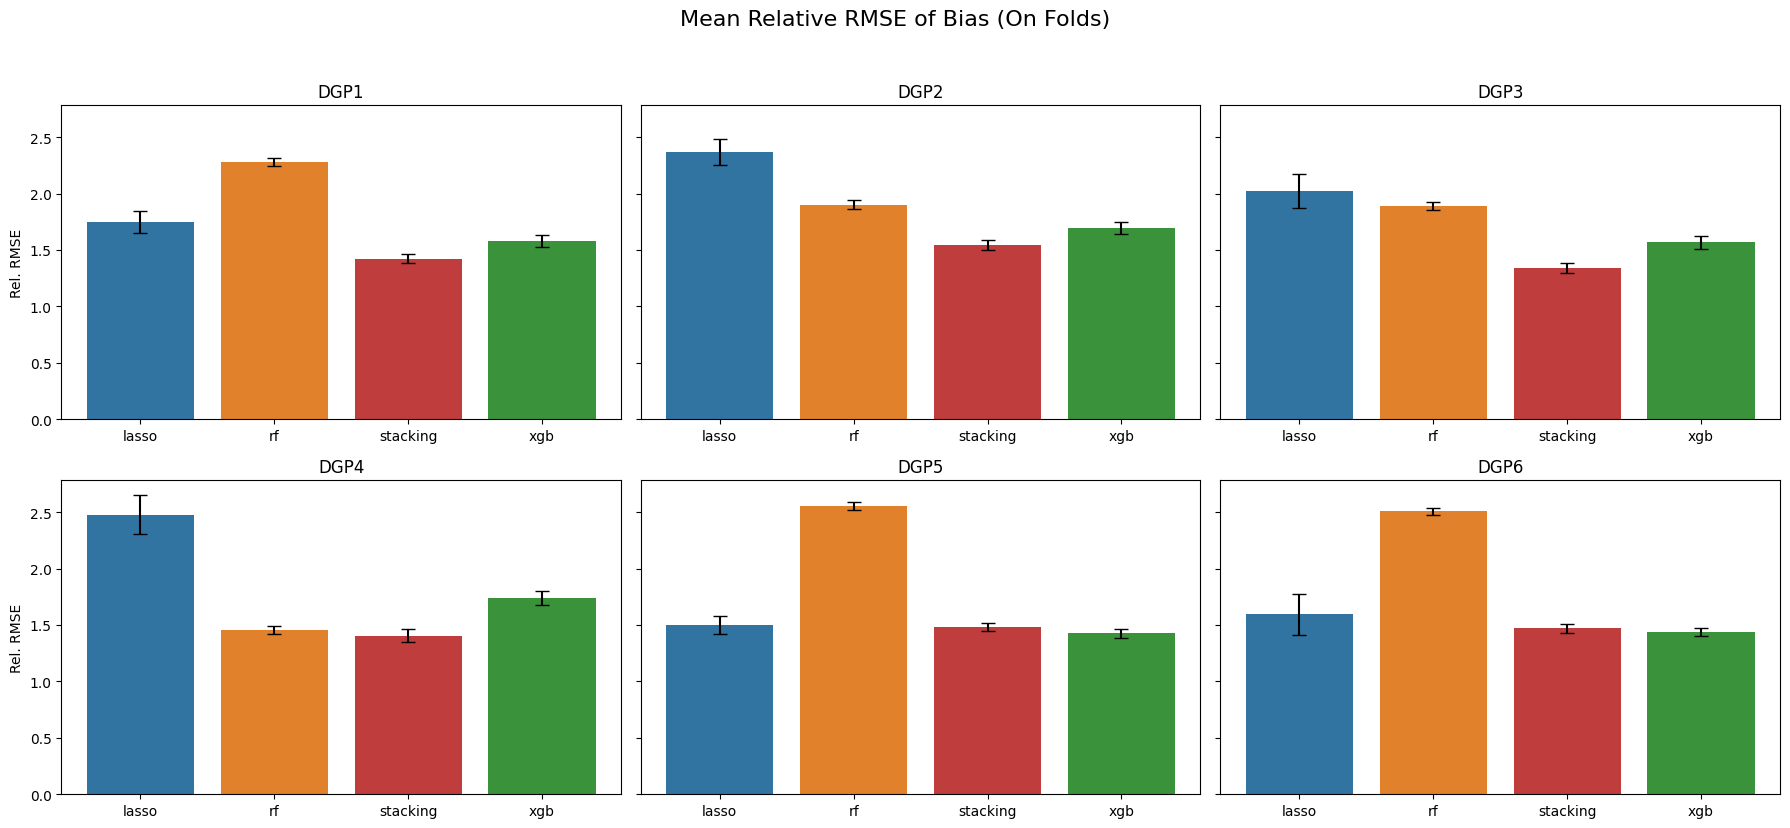

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharey=True)
dgps = ['dgp1', 'dgp2', 'dgp3', 'dgp4', 'dgp5', 'dgp6']
titles = [f"DGP{i+1}" for i in range(6)]

for i, dgp in enumerate(dgps):
    row, col = divmod(i, 3)
    ax = axes[row, col]

    df_temp = df_rmses[df_rmses['DGP'] == dgp]

    df_bar = (
        df_temp.groupby("Model")["Relative RMSE"]
        .mean()
        .reset_index()
        .rename(columns={"Relative RMSE": "Mean Relative RMSE"})
    )

    df_bar["SE"] = df_bar["Model"].apply(lambda m: relative_se.get((dgp, m), np.nan))

    sns.barplot(
        data=df_bar,
        x="Model",
        y="Mean Relative RMSE",
        hue="Model",
        dodge=False,
        ax=ax,
        palette=[color_map_models.get(model, '#333333') for model in df_bar['Model']],
        capsize=0.1
    )

    for j, row in df_bar.iterrows():
        ax.errorbar(
            x=j,
            y=row["Mean Relative RMSE"],
            yerr=row["SE"],
            fmt='none',
            c='black',
            capsize=5,
            linewidth=1.5
        )

    ax.set_title(titles[i])
    ax.set_xlabel("")
    ax.set_ylabel("Rel. RMSE" if col == 0 else "")
    ax.legend().remove()

plt.suptitle("Mean Relative RMSE of Bias (On Folds)", fontsize=16, y=1.03)
plt.tight_layout()
plt.show()


In [11]:
df_bar

,Model,Mean Relative RMSE,SE
0,lasso,1.594437,0.181320
1,rf,2.505826,0.034472
2,stacking,1.472735,0.040219
3,xgb,1.437664,0.038491


# Nuisance Errors

In [12]:
import pandas as pd
import numpy as np

def rmse(x):
    return np.sqrt(np.mean(x))

def compute_summary():
    summary = []

    for dgp in dgps:
        for model in models:
            subset = dfs[dgp][dfs[dgp]['model'] == model]

            pi_loss = subset['ml_pi_log_loss']
            m_loss = subset['ml_m_log_loss']
            g_rmse   = subset['ml_g_rmse']

            # Combined loss
            combined_loss = g_rmse * (pi_loss + m_loss)

            summary.append({
                'DGP': dgp,
                'Model': model,
                'Mean logloss(π)': pi_loss.mean(),
                'SE logloss(π)': pi_loss.std(ddof=1) / np.sqrt(len(pi_loss)),
                'Mean logloss(m)': m_loss.mean(),
                'SE logloss(m)': m_loss.std(ddof=1) / np.sqrt(len(m_loss)),
                'Mean RMSE(g)': g_rmse.mean(),
                'SE RMSE(g)': g_rmse.std(ddof=1) / np.sqrt(len(g_rmse)),
                'Mean Combined Loss': combined_loss.mean(),
                'SE Combined Loss': combined_loss.std(ddof=1) / np.sqrt(len(combined_loss))
            })

    return pd.DataFrame(summary)

df_summary = compute_summary()

In [13]:
df_summary

,DGP,Model,Mean logloss(π),SE logloss(π),Mean logloss(m),SE logloss(m),Mean RMSE(g),SE RMSE(g),Mean Combined Loss,SE Combined Loss
0,dgp1,lasso,0.425684,0.000430,0.574354,0.000658,1.123243,0.001048,1.123348,0.001462
1,dgp1,rf,0.520835,0.000337,0.570514,0.000655,1.144451,0.001136,1.249053,0.001621
2,dgp1,xgb,0.447340,0.000459,0.552376,0.000858,1.181737,0.001099,1.181449,0.001699
3,dgp1,stacking,0.464620,0.000390,0.565748,0.000648,1.150103,0.001012,1.185086,0.001480
4,dgp1,oracle,0.413207,0.000533,0.436101,0.000251,0.942698,0.000681,0.800662,0.000849
5,dgp2,lasso,0.425684,0.000430,0.574354,0.000658,1.433059,0.001434,1.433172,0.001907
6,dgp2,rf,0.520696,0.000333,0.570356,0.000668,1.297713,0.001340,1.415921,0.001863
7,dgp2,xgb,0.447549,0.000477,0.552362,0.000877,1.316474,0.001413,1.316386,0.001987
8,dgp2,stacking,0.464643,0.000394,0.565691,0.000663,1.350480,0.001254,1.391497,0.001767
9,dgp2,oracle,0.413207,0.000533,0.436101,0.000251,0.942698,0.000681,0.800662,0.000849


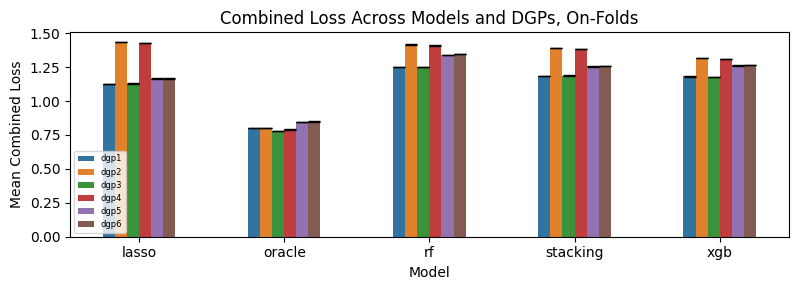

In [14]:
def plot_metric_bar(df_summary, metric_col, se_col, title):
    import matplotlib.pyplot as plt
    import seaborn as sns
    df_summary_sorted = df_summary.sort_values(by=['Model', 'DGP']).reset_index(drop=True)

    # Plot
    plt.figure(figsize=(8, 3))
    ax = sns.barplot(
        data=df_summary_sorted,
        x='Model',
        y=metric_col,
        hue='DGP',
        errorbar=None,
        dodge=True,
        width=0.5
    )

    for idx, patch in enumerate(ax.patches[:len(df_summary_sorted)]):
        row = df_summary_sorted.iloc[idx]
        x = patch.get_x() + patch.get_width() / 2
        y = patch.get_height()
        se = row[se_col]
        ax.errorbar(x=x, y=y, yerr=se, fmt='none', c='black', capsize=4, linewidth=1.2)

    plt.title(title)
    plt.legend(fontsize = 6)
    plt.ylabel(metric_col)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

#plot_metric_bar(df_summary, 'Mean logloss(π)', 'SE logloss(π)', 'Log Loss (π) Across Models and DGPs, Full Sample')
#plot_metric_bar(df_summary, 'Mean logloss(m)', 'SE logloss(m)', 'Log Loss (m) Across Models and DGPs, Full Sample')
#plot_metric_bar(df_summary, 'Mean RMSE(g)', 'SE RMSE(g)', 'RMSE (g) Across Models and DGPs, Full Sample')
plot_metric_bar(df_summary, 'Mean Combined Loss', 'SE Combined Loss', 'Combined Loss Across Models and DGPs, On-Folds')

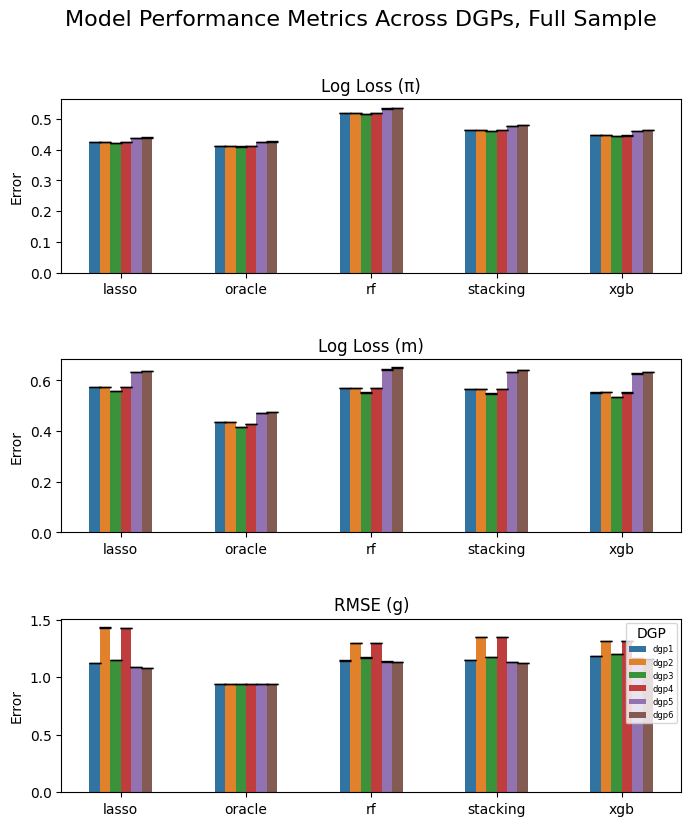

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.gridspec import GridSpec

def plot_all_metrics_vertically(df_summary, title):
    metrics = [
        ('Mean logloss(π)', 'SE logloss(π)', 'Log Loss (π)'),
        ('Mean logloss(m)', 'SE logloss(m)', 'Log Loss (m)'),
        ('Mean RMSE(g)', 'SE RMSE(g)', 'RMSE (g)')
    ]

    df_summary_sorted = df_summary.sort_values(by=['Model', 'DGP']).reset_index(drop=True)

    fig = plt.figure(figsize=(8, 9))
    gs = GridSpec(3, 1, hspace=0.5)

    axes = [fig.add_subplot(gs[i, 0]) for i in range(3)]

    for i, (metric_col, se_col, subtitle) in enumerate(metrics):
        ax = axes[i]

        sns.barplot(
            data=df_summary_sorted,
            x='Model',
            y=metric_col,
            hue='DGP',
            errorbar=None,
            dodge=True,
            width=0.5,
            ax=ax
        )

        for idx, patch in enumerate(ax.patches[:len(df_summary_sorted)]):
            row = df_summary_sorted.iloc[idx]
            x = patch.get_x() + patch.get_width() / 2
            y = patch.get_height()
            se = row[se_col]
            ax.errorbar(x=x, y=y, yerr=se, fmt='none', c='black', capsize=4, linewidth=1.2)

        ax.set_title(subtitle, fontsize=12)
        ax.set_xlabel('')
        ax.set_ylabel('Error')
        ax.set_ylim(bottom=0)

        if i < 2:
            ax.get_legend().remove()
        else:
            ax.legend(title='DGP', fontsize=6, title_fontsize=10, loc='upper right')

    fig.suptitle(title, fontsize=16, y=0.98)
    plt.show()

plot_all_metrics_vertically(df_summary, 'Model Performance Metrics Across DGPs, Full Sample')


/var/folders/wz/8dx1hr751n3cqyl25t_3q4240000gn/T/ipykernel_89372/1534176257.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/wz/8dx1hr751n3cqyl25t_3q4240000gn/T/ipykernel_89372/1534176257.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/wz/8dx1hr751n3cqyl25t_3q4240000gn/T/ipykernel_89372/1534176257.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


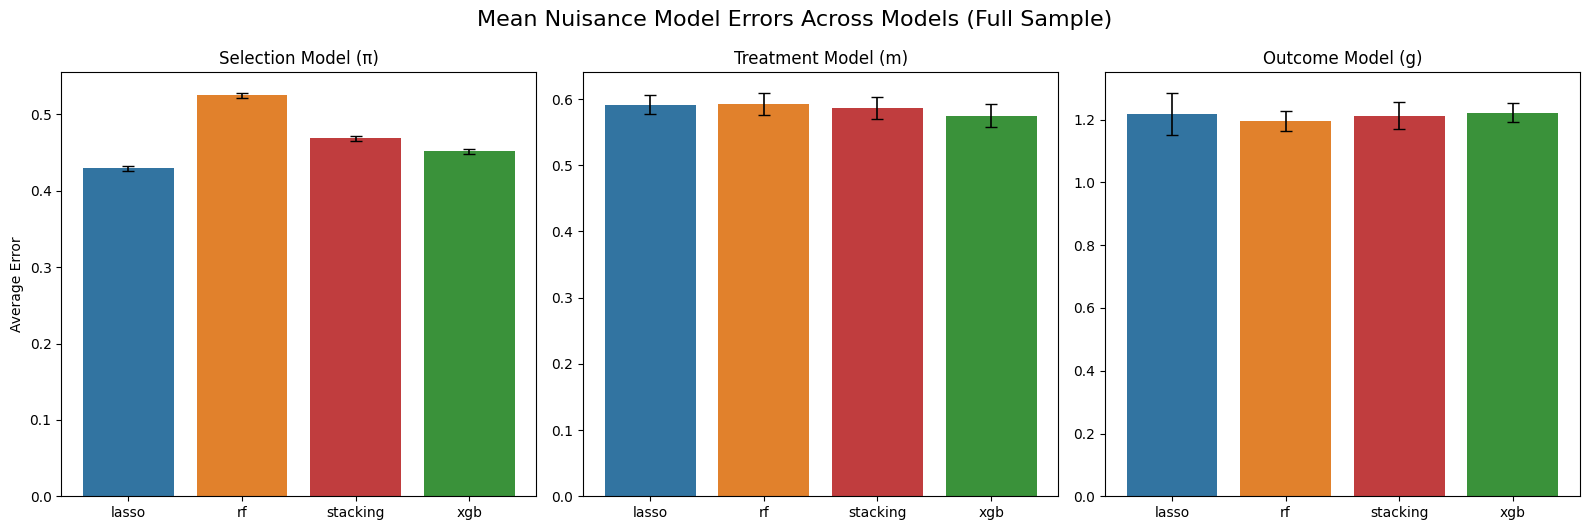

In [16]:
def plot_nuisance_errors_side_by_side(df_summary, overall_title):
    metrics = {
        'Mean logloss(π)': 'Selection Model (π)',
        'Mean logloss(m)': 'Treatment Model (m)',
        'Mean RMSE(g)': 'Outcome Model (g)'
    }

    color_map = {
        'lasso': '#1f77b4',
        'rf': '#ff7f0e',
        'xgb': '#2ca02c',
        'stacking': '#d62728'
    }

    fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=False)

    for i, (metric_col, title) in enumerate(metrics.items()):
        ax = axes[i]

        # Ortalama ve SE hesapla
        df_agg = (
            df_summary.groupby('Model')
            .agg(
                mean_metric=(metric_col, 'mean'),
                se_metric=(metric_col, lambda x: x.std(ddof=1) / np.sqrt(len(x)))
            )
            .reset_index()
        )

        sns.barplot(
            data=df_agg,
            x='Model',
            y='mean_metric',
            palette=[color_map.get(m, '#333333') for m in df_agg['Model']],
            errorbar=None,
            ax=ax
        )

        for j, row in df_agg.iterrows():
            ax.errorbar(
                x=j,
                y=row['mean_metric'],
                yerr=row['se_metric'],
                fmt='none',
                c='black',
                capsize=4,
                linewidth=1.2
            )

        ax.set_title(title)
        ax.set_xlabel('')
        if i == 0:
            ax.set_ylabel('Average Error')
        else:
            ax.set_ylabel('')
        ax.set_ylim(bottom=0)

    
    plt.tight_layout()
    plt.suptitle(overall_title, fontsize=16, y=1.05)
    plt.show()

plot_nuisance_errors_side_by_side(df_summary[df_summary['Model']!='oracle'], 'Mean Nuisance Model Errors Across Models (Full Sample)')

# Nuisance Errors Grouped by DGPs

In [17]:
rel_losses = []

for dgp in df_summary['DGP'].unique():
    df_dgp = df_summary[df_summary['DGP'] == dgp]
    oracle_row = df_dgp[df_dgp['Model'] == 'oracle'].iloc[0]
    
    for _, row in df_dgp.iterrows():
        if row['Model'] == 'oracle':
            continue  # Oracle'ı kıyaslamaya dahil etme
        
        rel_losses.append({
            'DGP': dgp,
            'Model': row['Model'],
            'Relative Combined Loss': row['Mean Combined Loss'] / oracle_row['Mean Combined Loss'],
            'Relative logloss(π)': row['Mean logloss(π)'] / oracle_row['Mean logloss(π)'],
            'Relative logloss(m)': row['Mean logloss(m)'] / oracle_row['Mean logloss(m)'],
            'Relative RMSE(g)': row['Mean RMSE(g)'] / oracle_row['Mean RMSE(g)'],
        })

df_rel = pd.DataFrame(rel_losses)

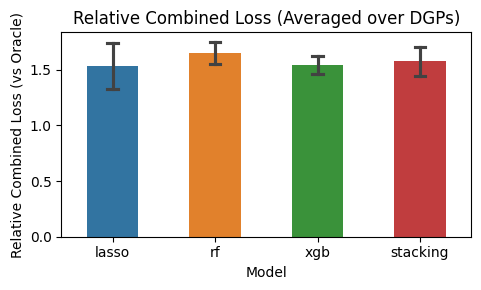

In [18]:
plt.figure(figsize=(5, 3))
sns.barplot(
    data=df_rel,
    x='Model',
    y='Relative Combined Loss',
    estimator='mean',
    errorbar='sd',
    capsize=0.1,
    hue='Model',
    width=0.5  
)
plt.title('Relative Combined Loss (Averaged over DGPs)')
plt.ylabel('Relative Combined Loss (vs Oracle)')
plt.tight_layout()
plt.show()

# Coverage

In [19]:
def get_coverage(lower, upper, true_value):
    return np.mean((lower <= true_value) & (true_value <= upper))

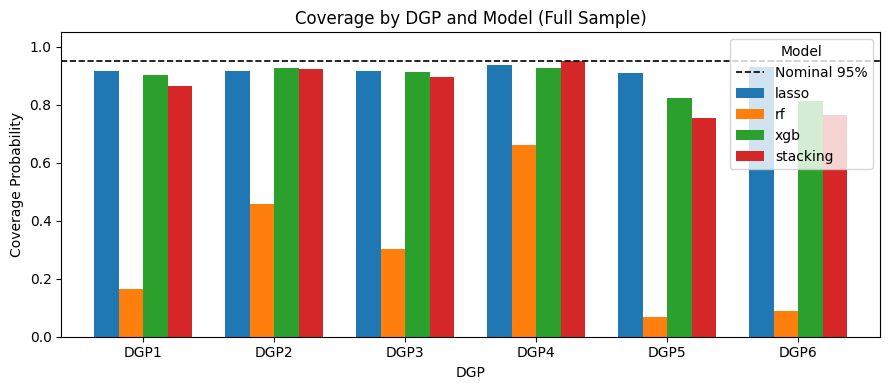

In [20]:

data = []
for dgp in dgps:
    for model_type in models_without_oracle:
        df_temp = dfs[dgp][dfs[dgp]['model'] == model_type]
        coverage = get_coverage(df_temp['2.5 %'], df_temp['97.5 %'], 1)
        data.append({
            'DGP': dgp.upper(),
            'Model': model_type,
            'Coverage': coverage
        })

df_plot = pd.DataFrame(data)

pivot_df = df_plot.pivot(index='DGP', columns='Model', values='Coverage')
pivot_df = pivot_df[models_without_oracle]  
color_map = {
    'lasso': '#1f77b4',
    'rf': '#ff7f0e',
    'xgb': '#2ca02c',
    'stacking': '#d62728'
}
colors = [color_map[m] for m in pivot_df.columns]

ax = pivot_df.plot(
    kind='bar',
    figsize=(9, 4),
    width=0.75,
    color=colors
)

plt.axhline(0.95, linestyle='--', color='black', linewidth=1.2, label='Nominal 95%')
plt.ylabel('Coverage Probability')
plt.title('Coverage by DGP and Model (Full Sample)')
plt.ylim(0, 1.05)
plt.xticks(rotation=0)
plt.legend(title='Model', loc='upper right')
plt.tight_layout()
plt.show()


# Theta Estimate Distrbiutions

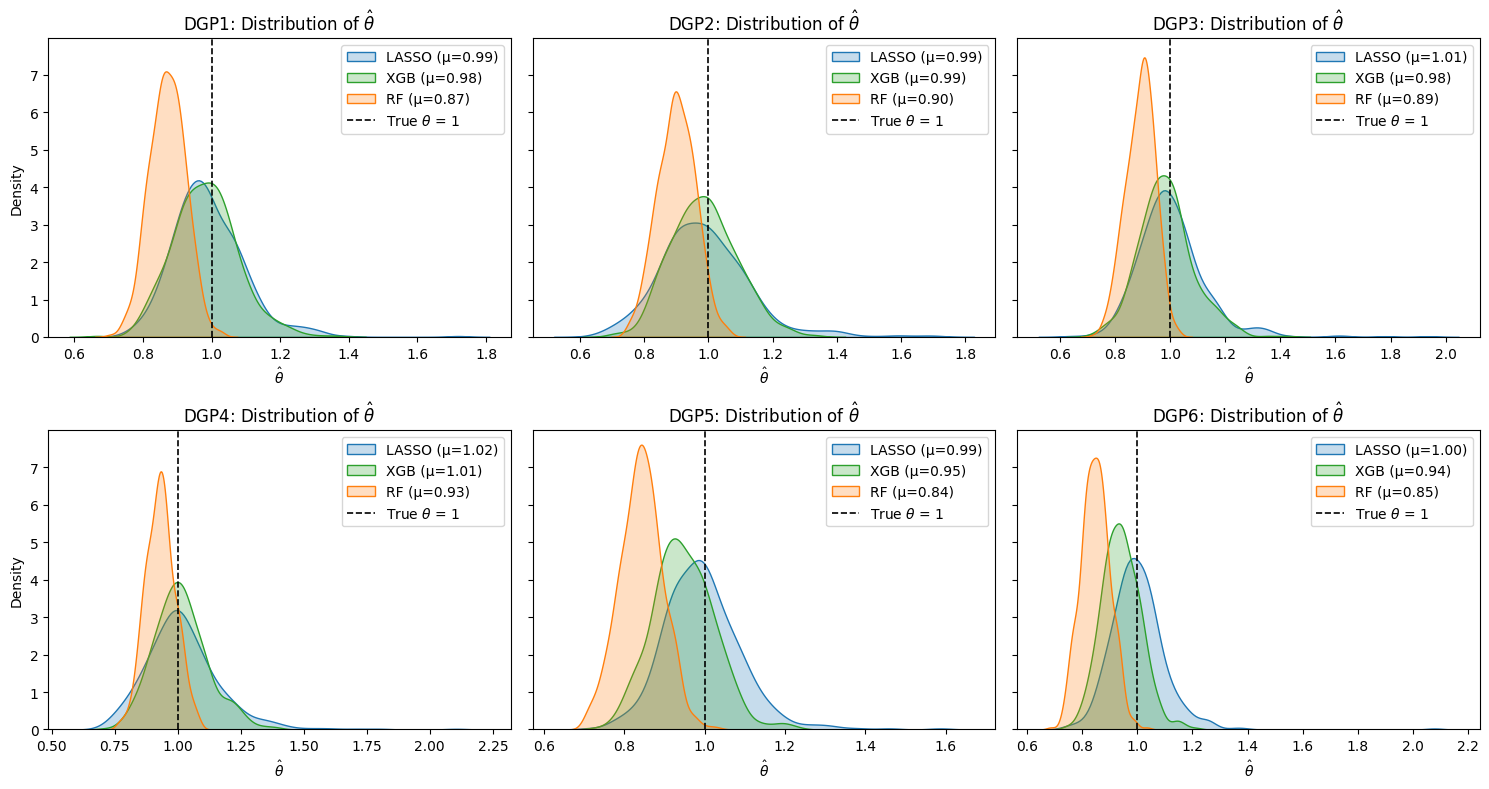

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

titles = ['DGP1', 'DGP2', 'DGP3', 'DGP4', 'DGP5', 'DGP6']
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=True)
axes = axes.flatten()

for i, dgp in enumerate(dgps):
    ax = axes[i]
    df_temp = dfs[dgp]

    for model in ['lasso', 'xgb','rf']:
        subset = df_temp[df_temp['model'] == model]
        mean_theta = subset['theta_hat'].mean()
        label = f'{model.upper()} (μ={mean_theta:.2f})'
        sns.kdeplot(
            data=subset,
            x='theta_hat',
            label=label,
            fill=True,
            common_norm=False,
            ax=ax,
            color=color_map_models[model]
        )

    ax.axvline(1.0, color='black', linestyle='--', linewidth=1.2, label='True $\\theta$ = 1')
    ax.set_title(f'{titles[i]}: Distribution of $\\hat\\theta$')
    ax.set_xlabel('$\\hat\\theta$')
    if i % 3 == 0:
        ax.set_ylabel('Density')
    else:
        ax.set_ylabel('')
    ax.legend()

plt.tight_layout()
plt.show()


# Bias Distribution

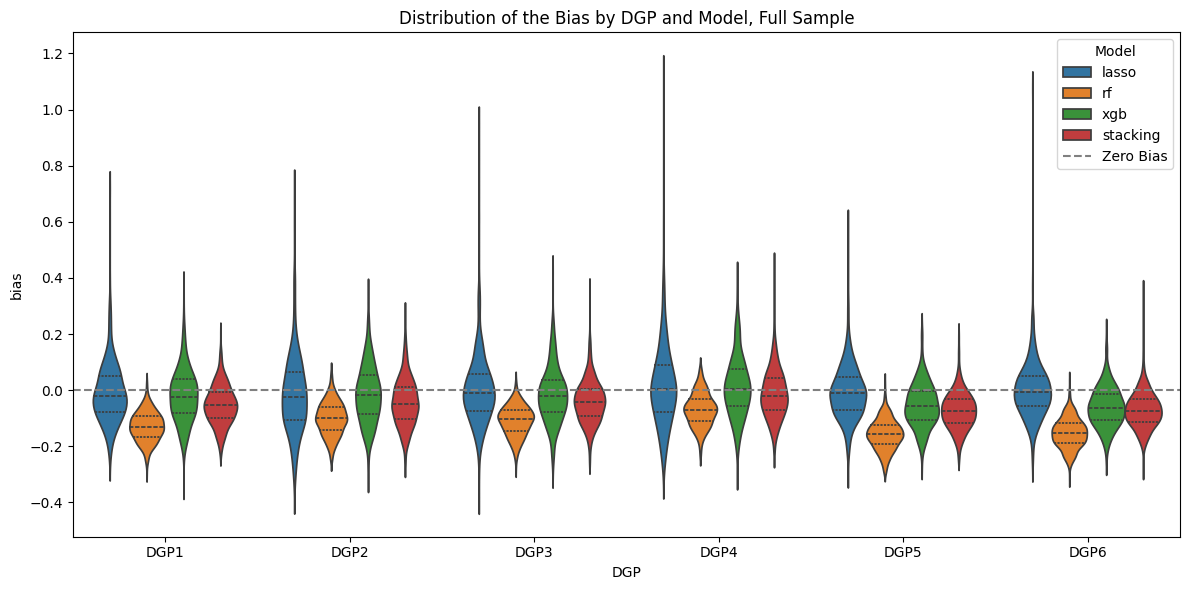

In [22]:
# dfs: {'dgp4': df4, 'dgp5': df5, ...}
df_all = pd.concat(
    [df.assign(DGP=dgp.upper()) for dgp, df in dfs.items()],
    ignore_index=True
)

df_all = df_all[df_all['model'] != 'oracle']
def plot_theta_violin(df, bias_col='bias'):
    plt.figure(figsize=(12, 6))
    sns.violinplot(
        data=df, 
        x='DGP', 
        y=bias_col, 
        hue='model', 
        inner='quartile'
    )
    plt.axhline(0.0, linestyle='--', color='gray', label='Zero Bias')
    plt.title('Distribution of the Bias by DGP and Model, Full Sample')
    plt.ylabel('bias')
    plt.xlabel('DGP')
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()

# Plotla
plot_theta_violin(df_all)

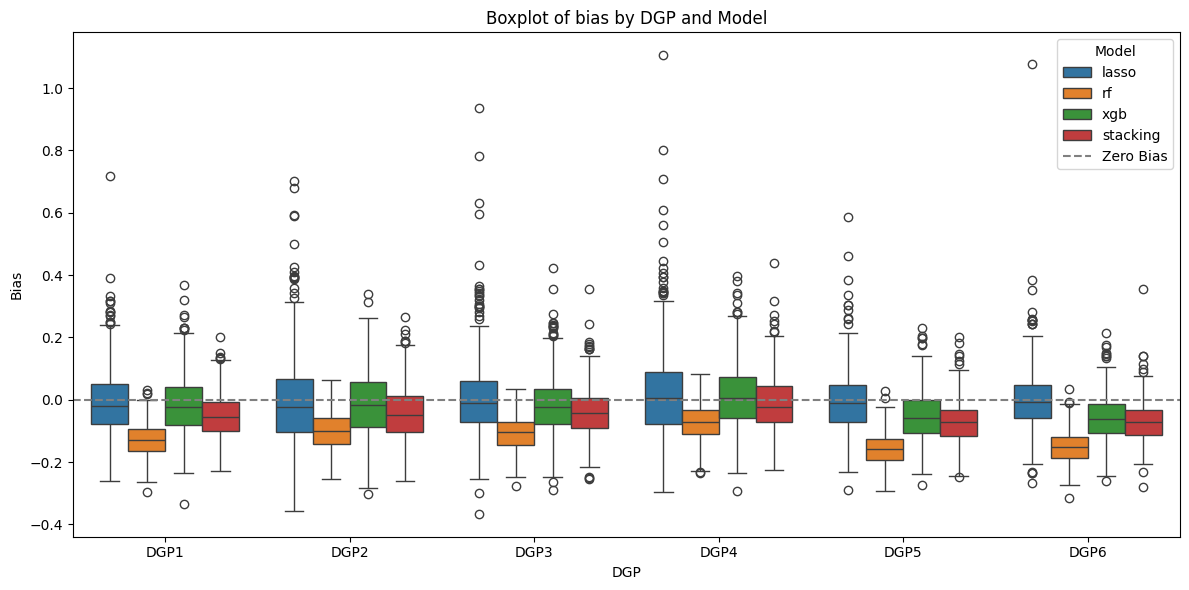

In [23]:
def plot_theta_boxplot(df, bias_col='bias'):
    plt.figure(figsize=(12, 6))
    sns.boxplot(
        data=df,
        x='DGP',
        y=bias_col,
        hue='model'
    )
    plt.axhline(0, linestyle='--', color='gray', label='Zero Bias')
    plt.title('Boxplot of bias by DGP and Model')
    plt.ylabel('Bias')
    plt.xlabel('DGP')
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()

plot_theta_boxplot(df_all)

# Combined Loss - Bias

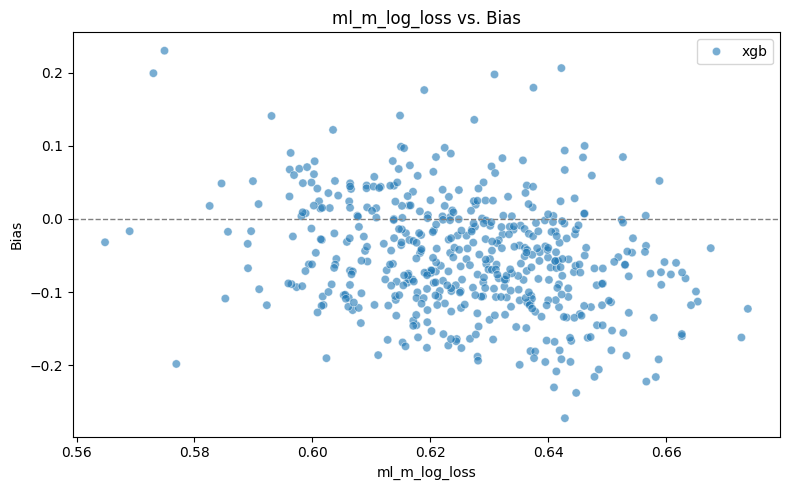

In [25]:
df_temp = dfs['dgp5'][dfs['dgp5']['model']=='xgb']
outcome_of_int = 'ml_m_log_loss'
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_temp, x=outcome_of_int, y='bias', hue='model', alpha=0.6)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title(f'{outcome_of_int} vs. Bias')
plt.xlabel(f'{outcome_of_int}')
plt.ylabel('Bias')
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/wz/8dx1hr751n3cqyl25t_3q4240000gn/T/ipykernel_89372/2957476254.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['abs_bias'] = df_temp['bias'].abs()


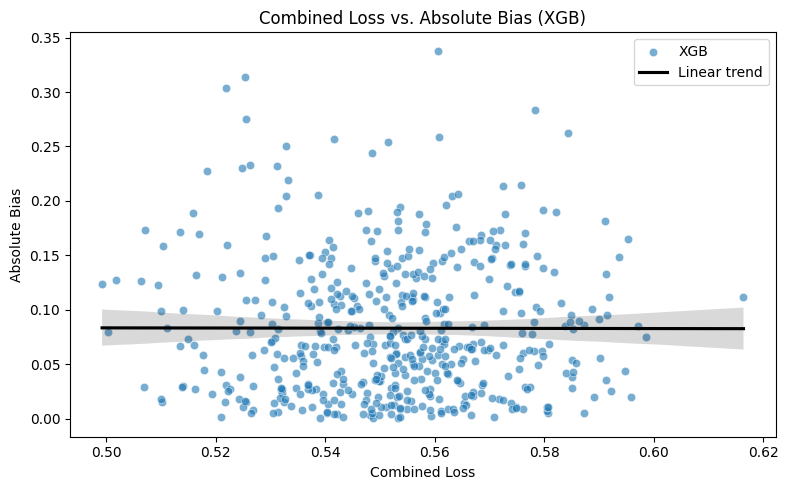

In [26]:
df_temp = dfs['dgp2'][dfs['dgp2']['model']=='xgb']
outcome_of_int = 'ml_m_log_loss'

df_temp['abs_bias'] = df_temp['bias'].abs()

plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_temp[df_temp['model'] == 'xgb'], x=outcome_of_int, y='abs_bias', alpha=0.6, label='XGB')

# Regresyon çizgisi
sns.regplot(
    data=df_temp[df_temp['model'] == 'xgb'],
    x=outcome_of_int,
    y='abs_bias',
    scatter=False,
    color='black',
    label='Linear trend'
)

plt.title('Combined Loss vs. Absolute Bias (XGB)')
plt.xlabel('Combined Loss')
plt.ylabel('Absolute Bias')
plt.legend()
plt.tight_layout()
plt.show()

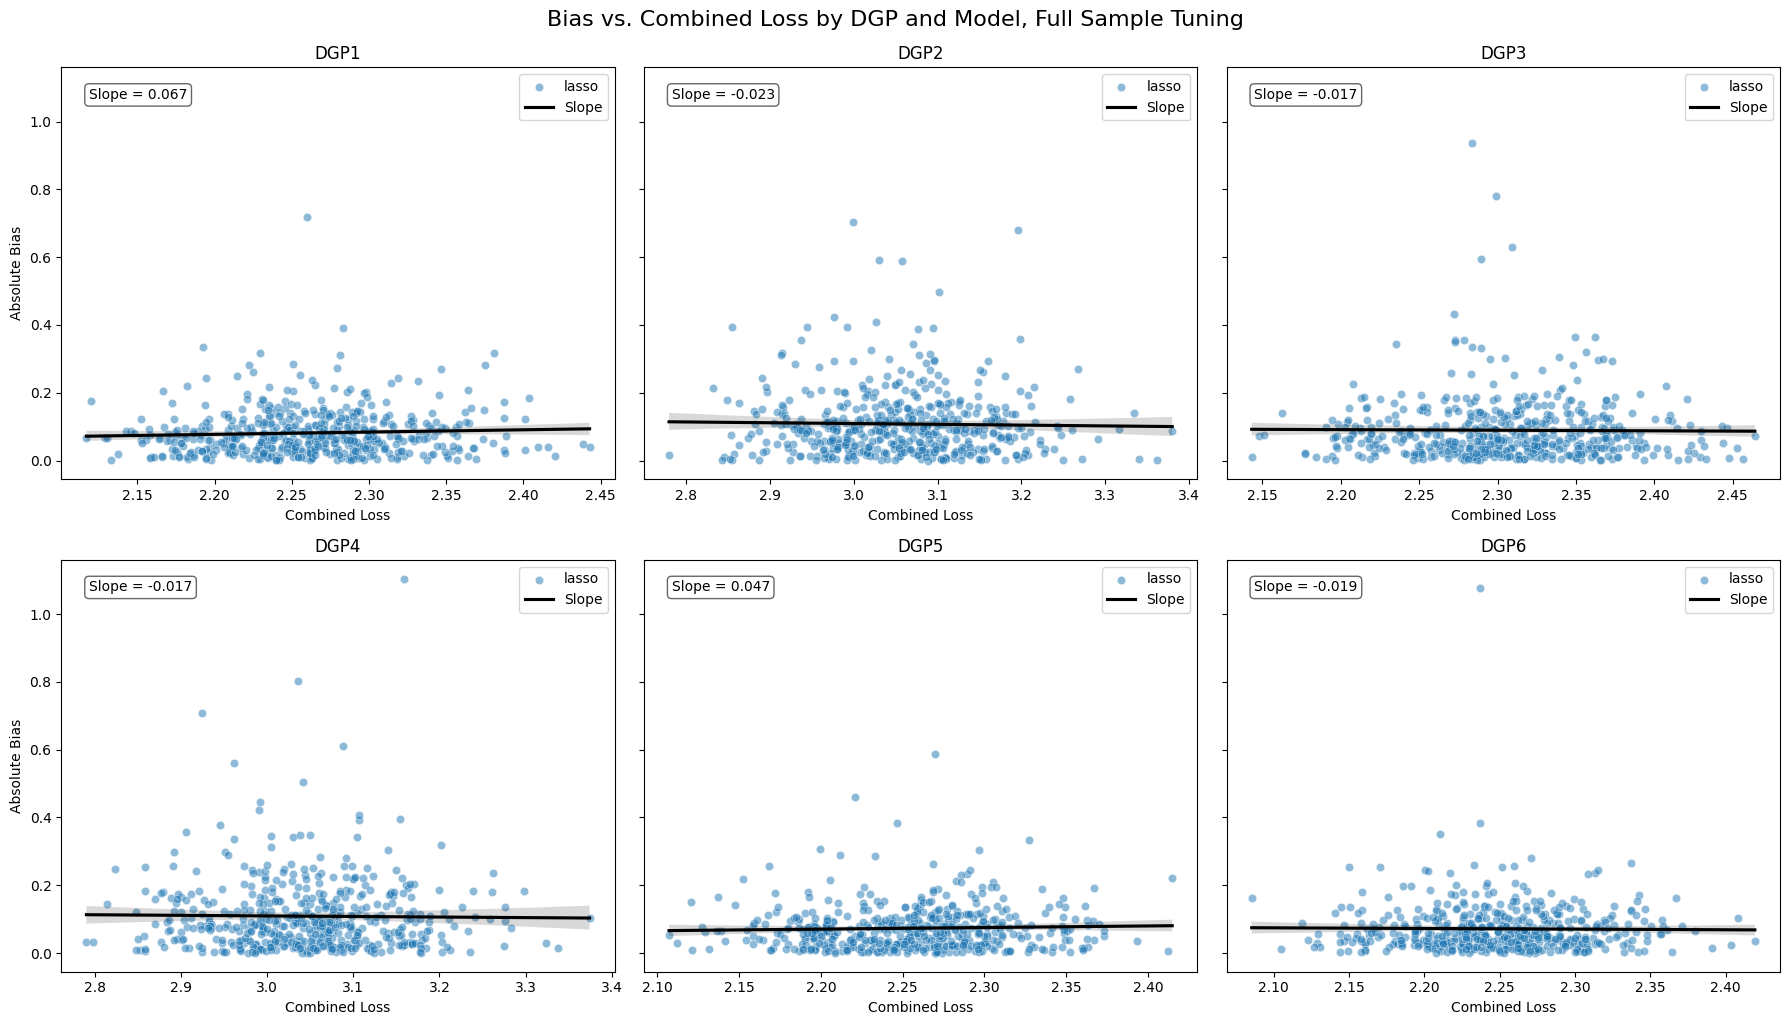

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# DGP'ler ve başlıklar
dgps = ['dgp1', 'dgp2', 'dgp3', 'dgp4', 'dgp5', 'dgp6']
titles = [f'DGP{i+1}' for i in range(6)]
outcome_of_int = 'combined_loss'
model = 'lasso'
# Subplot setup
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True)

for i, dgp in enumerate(dgps):
    row, col = divmod(i, 3)
    ax = axes[row, col]

    df_temp = dfs[dgp][dfs[dgp]['model'] == model].copy()
    df_temp['abs_bias'] = df_temp['bias'].abs()

    # Scatter + regression
    sns.scatterplot(data=df_temp, x=outcome_of_int, y='abs_bias', alpha=0.5, ax=ax, label=model)
    sns.regplot(data=df_temp, x=outcome_of_int, y='abs_bias', scatter=False, color='black', ax=ax, label='Slope')

    # Slope hesapla
    slope, intercept = np.polyfit(df_temp[outcome_of_int], df_temp['abs_bias'], deg=1)
    slope_text = f"Slope = {slope:.3f}"
    ax.text(0.05, 0.95, slope_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.6))

    ax.set_title(f'{titles[i]}')
    ax.set_xlabel('Combined Loss')
    if col == 0:
        ax.set_ylabel('Absolute Bias')
    else:
        ax.set_ylabel('')
    ax.legend()


plt.tight_layout()
fig.suptitle('Bias vs. Combined Loss by DGP and Model, Full Sample Tuning', fontsize=16, y=1.02)
plt.show()

